In [1]:
#meta 5/3/2021 myClassify (multiclass) for WOS5736 - Train model with fast.ai
# task: classify text (multiclass) 
# input: ../input/mywos-train/WOS5736_df_tidy.pkl
#      WOS5736 ds with only 11 labels
#      Important reset index - fast.ai dataloaders don't like a gap in index
#      to avoid -> TypeError: 'float' object is not iterable

#task: Multi-class text classification - supervised
#based on helloML/myNLP_lshtc3/kaggle_1_classify.ipynb

#$config mystop


#history
#      5/3/2021 FAST.AI in Kaggle
#      Initial Accuracy (train) ~75% 


In [2]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump


In [3]:
from fastai.text.all import *

In [4]:
#declare vars
SEED = 24

# LSHTC: Classify Text 
Train text classifier using Transfer Learning.  2 steps:  
1. fine-tune our language model pretrained on Wikipedia to the corpus of Expeditors survey  
2. use that model to train a classifier  



## 0. Load Data
input: a prepared pickle with pre-selected relevant fields.

In [10]:
df_tidy = load('../input/mywos-train/WOS5736_df_tidy.pkl') 
print(df_tidy.shape)
print(df_tidy.columns)
print(df_tidy.dtypes)
df_tidy.head()


(5736, 2)
Index(['text', 'label'], dtype='object')
text       object
label    category
dtype: object


,text,label
0,"Phytoplasmas are insect-vectored bacteria that cause disease in a wide range of plant species. The increasing availability of molecular DNA analyses, expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasma-plant host associations and in the numbers of taxonomic groupings for phytoplasmas. The widespread use of common names based on the diseases with which they are associated, as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16S rRNA-encoding gene, complicates interpretation of the lit...",9
1,"Background: (-)-alpha-Bisabolol, also known as levomenol, is an unsaturated sesquiterpene alcohol that has mainly been used in pharmaceutical and cosmetic products due to its anti-inflammatory and skin-soothing properties. (-)-alpha-Bisabolol is currently manufactured mainly by steam-distillation of the essential oils extracted from the Brazilian candeia tree that is under threat because its natural habitat is constantly shrinking. Therefore, microbial production of (-)-alpha-bisabolol plays a key role in the development of its sustainable production from renewable feedstock. Results: Here...",7
2,"A universal feature of the replication of positive-strand RNA viruses is the association with intracellular membranes. Carnation Italian ringspot virus (CIRV) replication in plants occurs in vesicles derived from the mitochondrial outer membrane. The product encoded by CIRV ORF1, p36, is required for targeting the virus replication complex to the outer mitochondrial membrane both in plant and yeast cells. Here the yeast Saccharomyces cerevisiae was used as a model host to study the effect of CIRV p36 on cell survival and death. It was shown that p36 does not promote cell death, but decreas...",7
3,"1,2-Dichloropropane (1,2-DCP) and dichloromethane (DCM) are possible causative agents associated with the development of cholangiocarcinoma in employees working in printing plant in Osaka, Japan. However, few reports have demonstrated an association between these agents and cholangiocarcinoma in rodent carcinogenicity studies. Moreover, the combined effects of these compounds have not been fully elucidated. In the present study, we evaluated the in vivo mutagenicity of 1,2-DCP and DCM, alone or combined, in the livers of gpt delta rats. Six-week-old male F344 gpt delta rats were treated wi...",9
4,"This paper presents the simulation results of a linear, fully integrated, two-stage digitally programmable 130 nm CMOS power amplifier (PA) operating at 2.4 GHz. Its power stage is composed of a set of amplifying cells which can be enabled or disabled independently by a digital control circuit. All seven operational modes are univocal in terms of 1 dB output compression point (OCP1dB), saturated output power (P-SAT) and power gain at 2.4 GHz. The lowest power mode achieves an 8.1 dBm P-SAT, a 13.5 dB power gain and consumes 171 mW DC power (P-DC) at an OCP1dB of 6 dBm, whereas the highest ...",1


In [11]:
#clean df
df = df_tidy[['text', 'label']].copy()

#reset index - dataloaders don't like a gap in index
#to fix error in next cell: TypeError: 'float' object is not iterable
#df.reset_index(drop=True, inplace=True)

df.head(2)

,text,label
0,"Phytoplasmas are insect-vectored bacteria that cause disease in a wide range of plant species. The increasing availability of molecular DNA analyses, expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasma-plant host associations and in the numbers of taxonomic groupings for phytoplasmas. The widespread use of common names based on the diseases with which they are associated, as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16S rRNA-encoding gene, complicates interpretation of the lit...",9
1,"Background: (-)-alpha-Bisabolol, also known as levomenol, is an unsaturated sesquiterpene alcohol that has mainly been used in pharmaceutical and cosmetic products due to its anti-inflammatory and skin-soothing properties. (-)-alpha-Bisabolol is currently manufactured mainly by steam-distillation of the essential oils extracted from the Brazilian candeia tree that is under threat because its natural habitat is constantly shrinking. Therefore, microbial production of (-)-alpha-bisabolol plays a key role in the development of its sustainable production from renewable feedstock. Results: Here...",7


## 1. Data Prep for fast.ai
Prepare our data for the language model and for the classification model separately, using fast.ai library.

### 1.1 Data Prep for Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. `DataBlock`'s handy `summary` method is useful for debugging data issues.


Putting Our Texts into Batches for a Language Model

In [12]:
#src https://docs.fast.ai/text.data.html#TextDataLoaders.from_df
#dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_col='is_valid')
dls_lm = TextDataLoaders.from_df(df, text_col='text', is_lm=True, valid_pct = 0.20, splitter=RandomSplitter(valid_pct = 0.15, seed = SEED)) 
dls_lm.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj inflammation is a local response to infection and tissue damage mediated by activated macrophages , monocytes , and other immune cells that release cytokines and other mediators of inflammation . xxmaj for a long time , humoral and cellular mechanisms have been studied for their role in regulating the immune response , but recent advances in the field of immunology and neuroscience have also unraveled specific neural mechanisms with interesting","xxmaj inflammation is a local response to infection and tissue damage mediated by activated macrophages , monocytes , and other immune cells that release cytokines and other mediators of inflammation . xxmaj for a long time , humoral and cellular mechanisms have been studied for their role in regulating the immune response , but recent advances in the field of immunology and neuroscience have also unraveled specific neural mechanisms with interesting therapeutic"
1,"technique will further expand the capability to achieve the best results . xxbos xxmaj objective : xxmaj ulinastatin reduces the high permeability of vascular endothelial cells induced by tumor necrosis factor alpha ( inf - alpha ) . xxmaj this study investigated the molecular mechanism behind this effect , with the aim of understanding the action of ulinastatin in sepsis therapy and exploring novel therapeutic strategies for sepsis patients . xxmaj methods","will further expand the capability to achieve the best results . xxbos xxmaj objective : xxmaj ulinastatin reduces the high permeability of vascular endothelial cells induced by tumor necrosis factor alpha ( inf - alpha ) . xxmaj this study investigated the molecular mechanism behind this effect , with the aim of understanding the action of ulinastatin in sepsis therapy and exploring novel therapeutic strategies for sepsis patients . xxmaj methods :"
2,") , with a positive predictive value of 70 % ( ci xxunk - xxunk % ) and negative predictive value of xxunk % ( ci xxunk - xxunk % ) . xxmaj antimicrobial therapy was xxunk after 16s rrna xxup pcr results in five patients ( 15.6 % ) and was ceased in four based on negative results ( 12.5 % ) . xxmaj overall the 16s rrna xxup pcr result",", with a positive predictive value of 70 % ( ci xxunk - xxunk % ) and negative predictive value of xxunk % ( ci xxunk - xxunk % ) . xxmaj antimicrobial therapy was xxunk after 16s rrna xxup pcr results in five patients ( 15.6 % ) and was ceased in four based on negative results ( 12.5 % ) . xxmaj overall the 16s rrna xxup pcr result had"


In [13]:
#dataset dims
len(dls_lm.train_ds), len(dls_lm.valid_ds)

(4589, 1147)

In [14]:
#view vocab, class list
print("LM vocab size: ", len(dls_lm.vocab))
dls_lm.vocab[5:100]

LM vocab size:  21408


['xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 '-',
 'to',
 ')',
 '(',
 'a',
 'with',
 'for',
 'is',
 'that',
 'was',
 'by',
 'were',
 'this',
 'as',
 'on',
 'are',
 'from',
 'we',
 'an',
 ':',
 '/',
 'be',
 '%',
 'or',
 'expression',
 'results',
 'study',
 'at',
 'these',
 'which',
 'cells',
 'have',
 'using',
 'patients',
 'has',
 'cell',
 'all',
 'can',
 'between',
 'c',
 'not',
 'control',
 'analysis',
 'it',
 'been',
 'their',
 'also',
 'used',
 'based',
 'high',
 'system',
 'gene',
 'time',
 ';',
 'protein',
 'may',
 'more',
 'two',
 'associated',
 'both',
 'than',
 'but',
 'levels',
 'power',
 'different',
 'treatment',
 '=',
 'its',
 '3',
 'molecular',
 'current',
 'however',
 'cancer',
 '1',
 'methods',
 'data',
 'model',
 'social',
 'compared',
 'showed',
 'after',
 'such',
 'elsevier',
 'our',
 'genes']

Data is ready, we can fine-tune the pretrained language model.

## 2. Model
The LM was pretrained on Wikipedia.  Fine-tune this LM to Expeditors survey corpus, and then use that as the base for our classifier.  
![ULMFiT Process](my-images/ch10_ULMFIT_process.png)
### 2.1 Fine-Tuning the Language Model


In [16]:
#class fastai.text.learner.LMLearner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

0.012023 0.022909


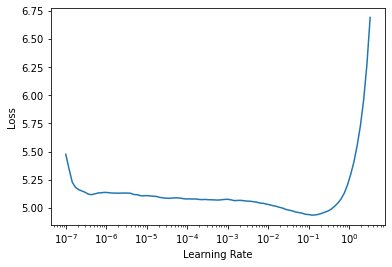

In [17]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [ ]:
#mystop

In [18]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.309458,4.160752,0.321933,64.119743,01:08


In [19]:
#save and load models
learn.save('1epoch')
#learn = learn.load('1epoch')

Path('models/1epoch.pth')

In [20]:
learn = learn.load('1epoch')

Once the initial training has completed, continue fine-tuning the model after unfreezing

In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, 4e-3) 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.617075,4.167711,0.321143,64.567474,01:15
1,3.475254,4.074332,0.330794,58.811169,01:16
2,3.022184,4.071590,0.335287,58.650139,01:16
3,2.501769,4.194732,0.333114,66.335930,01:16
4,2.096508,4.349518,0.328425,77.441116,01:15


In [22]:
#save model encoder
learn.save_encoder('finetuned')

In [23]:
#class fastai.text.learner.LMLearner
#learn.summary()

##### Text generation

In [24]:
TEXT = "The aim of this study was"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n".join(preds))

In [25]:
TEXT = "This paper presents"
N_WORDS = 40
N_SENTENCES = 2
#to predict, must be of class fastai.text.learner.LMLearner
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n".join(preds))

The aim of this study was to assess the relationship between high - level and perinatal health status among Chinese men with anxiety ( n = 185 ) and healthy controls ( n = 77 ) . In total , 121 residents and 87
The aim of this study was to evaluate the frequency and nature of the four - stage Operational Amplifier ( opamp ) opamp designed in Texas . The opamp has an open - loop gain of 25 db and a phase gain


In [ ]:
#mystop

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### 1.2 Data Prep for Classifier Model Using DataBlock
Creating the Classifier DataLoaders

In [27]:
dls_clf = TextDataLoaders.from_df(df, text_col='text', label_col='label', vocab=dls_lm.vocab, valid_pct = 0.25, splitter=RandomSplitter(0.25, seed = SEED))
dls_clf.show_batch(max_n=3)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj fresh ( frozen / thawed ) muscle samples from four 2 - xxunk - old roe deer ( xxunk xxunk ) from the xxmaj xxunk province in north - eastern xxmaj italy were examined under a dissecting microscope , and about 180 sarcocysts were isolated and identified to morphological type in wet xxunk by light microscopy ( lm ) . xxmaj seventy - seven of these sarcocysts were subsequently examined by molecular methods , comprising polymerase chain reaction ( pcr ) amplification and sequencing of the partial cytochrome c oxidase subunit i gene ( cox1 ) of all isolates , as well as xxup pcr amplification , cloning and sequencing of the xxunk ribosomal xxup rna ( rrna ) gene of two isolates of each species found . xxmaj by xxup lm , three major xxunk types were recognised : spindle - shaped sarcocysts , 0.5 - 3",9
1,"xxbos xxmaj problem . - xxmaj neurobiology , xxunk with the most recent discoveries of the molecular biology , the genetics and the cognitive sciences , is present everywhere : xxmaj in the report of the man with his body , with his intellectual xxunk , with his perception of others and himself . xxmaj our social xxunk , morality and our affects would be governed by neuronal xxunk . xxmaj are things so simple ? xxmaj methodology . - xxmaj to try to answer this question , the author is going to use the opposition "" to explain "" and "" understand "" , in a long - standing and often xxunk debate which concerns the xxunk and the ontology , two modalities to be xxunk . xxmaj different thus of methods : xxmaj in the mind of xxmaj xxunk , we explain the nature ( submitted to the",7
2,"xxbos xxmaj background : xxmaj the industrial xxunk fungus , xxmaj trichoderma reesei , is typically exploited for its ability to produce cellulase enzymes , whereas use of this fungus for over - expression of other proteins ( homologous and heterologous ) is still very limited . xxmaj identifying transformants expressing target protein is a tedious task due to low transformation efficiency , combined with highly variable expression levels between transformants . xxmaj routine methods for identification include pcr - based analysis , western blotting , or crude activity screening , all of which are time - consuming techniques . xxmaj to simplify this screening , we have adapted the 2a peptide system from the foot - and - mouth disease virus ( fmdv ) to xxup t. reesei to express a readily xxunk marker protein that is co - translated with a target protein . xxmaj the 2a peptide",7


In [28]:
len(dls_clf.train_ds), len(dls_clf.valid_ds)

(4302, 1434)

### 2.2 Model Classifier

In [29]:
#class fastai.text.learner.TextLearner
learn = text_classifier_learner(dls_clf, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Prior to training the classifier, load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded

In [30]:
learn = learn.load_encoder('finetuned')

##### Fine-tune classifier
The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference

0.0302 0.039811


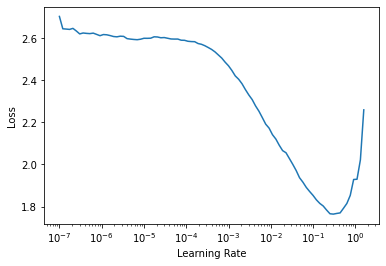

In [31]:
#select the appropriate lr
#learn.lr_find()
lr1, lr2 = learn.lr_find()
print(round(lr1, 6), round(lr2, 6))

In [35]:
#

In [36]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.090632,0.747286,0.737796,00:14


In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [37]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.791674,0.664942,0.768480,00:16


Unfreeze more and train

In [38]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.667662,0.647790,0.776151,00:24


Finally, the whole model

In [39]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.626908,0.642914,0.777545,00:30
1,0.635542,0.648589,0.775453,00:30


We reached 77% accuracy. 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful, to either generate fake reviews or help classify them. This is exciting stuff!

In [40]:
#learn.summary()
learn.show_results()

,text,category,category_
0,"xxbos xxmaj background : xxmaj in many parts of the xxmaj old xxmaj world , domesticated camels ( genus - xxmaj camelus ) are an essential resource , providing food , labor , commodities , and sport to millions of people xxmaj of the three extent species , two have been domesticated ( single - humped xxunk , xxmaj camelus xxunk , and two humped xxmaj bactrian camels xxmaj camelus xxunk ) and one remains wild ( two - humped wild xxmaj bactrian camels xxmaj camelus xxunk ) . xxmaj all three species possess a variety adaptations to harsh desert conditions , including mechanisms to tolerate of extreme temperatures , dehydration , and sandy terrain . xxmaj people residing in harsh climate zones of the world are being xxunk by raising camels in terms of draft , milk , meat , xxunk and xxunk from centuries . xxmaj there are",7,9
1,"xxbos xxmaj background : xxmaj hepatitis b virus ( hbv ) as an infectious disease that has nine genotypes ( a - i ) and a ' putative ' genotype xxup j. xxmaj objectives : xxmaj the aim of this study was to identify the rare codon clusters ( rcc ) in the xxup hbv genome and to evaluate these rccs in the xxup hbv proteins structure . xxmaj methods : xxmaj for detection of protein family accession numbers ( pfam ) in xxup hbv proteins , the xxunk database and xxmaj pfam search tool were used . xxmaj protein family accession numbers is a comprehensive and accurate collection of protein domains and families . xxmaj it contains annotation of each family in the form of textual descriptions , links to other resources and literature references . xxmaj genome projects have used p xxunk xxunk for large - scale functional",7,7
2,"xxbos xxmaj background : xxmaj knockdown resistance ( kdr ) , caused by alterations in the voltage - gated sodium channel ( na - v ) , is one of the mechanisms responsible for pyrethroid ( xxunk ) resistance . xxmaj in the xxmaj asian tiger mosquito , xxmaj aedes albopictus , at least four different mutations were described in the xxrep 3 i xxup s6 xxmaj na - v segment in populations from xxmaj asia , xxmaj north xxmaj america and xxmaj europe . xxmaj in contrast , in xxmaj aedes aegypti at least 12 non - synonymous mutations have been reported at nine different codons , mostly in the xxup iis6 and xxrep 3 i xxup s6 xxmaj na - v segments . xxmaj the xxunk kdr mutation in the xxrep 3 i xxup s6 xxmaj na - v segment is the most prevalent in populations of xxmaj",7,9
3,"xxbos xxmaj background : xxmaj impaired function of endothelial nitric oxide synthase ( enos ) is involved in the pathologic processes of erectile dysfunction ( ed ) , and three functional polymorphisms ( g894 t , xxup t-786c , and a tandem repeat of 27 bp in intron 4 ) in the xxup nos3 gene , which encodes enos , are associated with the clinical characteristics of xxup ed in several populations . xxmaj aim : xxmaj to investigate the effect of these variations of xxup nos3 on xxup ed phenotypes and the response to sildenafil in a xxmaj han xxmaj chinese population . xxmaj methods : xxmaj this case - control study enrolled 112 patients with xxup ed and 156 age - matched healthy men . xxmaj their medical history and laboratory data were collected . xxup ed severity and response to sildenafil were assessed using the five -",9,9
4,"xxbos xxmaj background & xxmaj aims : xxmaj induction of donor - specific immune tolerance is a good alternative to chronic life - long immunosuppression for transplant patients . xxmaj donor major histocompatibility complex ( mhc ) molecules represent the main targets of the allogeneic immune response of transplant recipients . xxmaj liver targeted gene transfer with viral vectors induces tolerance toward the encoded antigen . xxmaj the aim of this work was to determine whether alloantigen gene transfer to hepatocytes induces tolerance and promotes graft acceptance . xxmaj methods : xxup c57bl / 6 ( xxunk ) mice were treated with adeno - associated viral ( aav ) vector targeting

In [41]:
#save final model
learn.save('clf_final')
#export model as pkl
learn.export()

In [43]:
#mystop

## 3. Model Evaluation
src https://docs.fast.ai/interpret.html#ClassificationInterpretation  
src code https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51
### 3.1 Report and Confusion Matrix

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       114
           1       0.90      0.85      0.87       101
           2       0.87      0.96      0.91        98
           3       0.72      0.82      0.77        97
           4       0.88      0.88      0.88       105
           5       0.67      0.64      0.66        89
           6       0.68      0.50      0.57       105
           7       0.74      0.59      0.66       200
           8       0.80      0.75      0.77       168
           9       0.67      0.83      0.74       175
          10       0.85      0.84      0.84       182

    accuracy                           0.78      1434
   macro avg       0.78      0.78      0.78      1434
weighted avg       0.78      0.78      0.77      1434



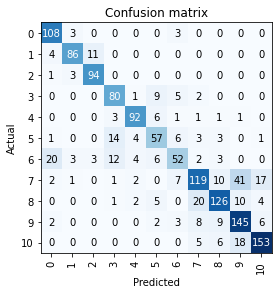

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [47]:
interp.most_confused(min_val = 10)

[(7, 9, 41),
 (6, 0, 20),
 (8, 7, 20),
 (10, 9, 18),
 (7, 10, 17),
 (5, 3, 14),
 (6, 3, 12),
 (1, 2, 11),
 (7, 8, 10),
 (8, 9, 10)]

In [48]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos xxmaj several prophylactic vaccines targeting herpes simplex virus 2 ( hsv-2 ) have failed in the clinic to demonstrate sustained depression of viral shedding or protection from recurrences . xxmaj although these vaccines have generated high titers of neutralizing antibodies ( xxunk ) , their induction of robust xxup cd8 t cells has largely been unreported , even though evidence for the importance of xxup hsv-2 antigen - specific xxup cd8 t cells is mounting in animal models and in translational studies involving subjects with active xxunk immune responses . xxmaj we developed a subunit vaccine composed of the nab targets gd and gb and the novel t cell antigen and xxunk protein xxup xxunk , and we compared this vaccine to a whole - inactivated - virus vaccine ( formaldehyde - inactivated xxup hsv-2 [ fi - hsv-2 ] ) . xxmaj we evaluated different formulations in combination",5,8,0.9864535927772522,7.640836238861084
1,"xxbos xxmaj functional electrical stimulation has been widely used for the restoration of bladder functions after spinal cord injury or other neurological disorders . xxmaj however , most of the xxunk for bladder control are still imperfect due to lack of the feedback information about the state of the controlled bladder . xxmaj the purpose of this study is to develop an implantable system which allows us to stimulate the nerves and record the nerve signals related to the condition of the bladder . xxmaj the proposed stimulator consists of three parts : a digital - to - analog converter ( dac ) , a current driver , and a switch network . xxmaj using the same current source with a switch network eliminates the need for separate current sources for anodic and cathodic sections and reduce the need for interconnect lines of control signals which is an area -",6,2,0.8805230259895325,7.570598602294922
2,"xxbos xxmaj this paper is concerned with the problem of model reduction for neutral - type control system . xxmaj for a given stable neutral - type control system , our attention is focused on the construction of a reduced - order model , which not only xxunk the original system well in a robust performance but is also translated into a linear lower - dimensional system . xxmaj sufficient condition is proposed for the asymptotic stability with an error performance for the error system . xxmaj then , the model reduction problem is solved by using the projection approach , which casts the model reduction subject to linear matrix inequality constraints by employing the cone complementary linearization algorithm . xxmaj moreover , by further extending the results , model reduction with special structures is obtained , i.e. , no neutral - type model . a numerical simulation example is",6,1,0.9642938375473022,7.0292792320251465
3,"xxbos xxmaj cognitive control enables successful goal - directed behavior by resolving a conflict between opposing action tendencies , while emotional control arises as a consequence of emotional conflict processing such as in xxunk . xxmaj while negative emotion facilitates both cognitive and emotional conflict processing , it is unclear how emotional conflict processing is affected by positive emotion ( e.g. , humor ) . xxmaj in 2 xxup eeg experiments , we investigated the role of positive audiovisual target stimuli in cognitive and emotional conflict processing . xxmaj participants categorized either spoken xxunk ( cognitive task ) or their emotional valence ( emotional task ) and ignored the visual stimulus dimension . xxmaj xxunk , a positive target showed no influence on cognitive conflict processing , but impeded emotional conflict processing . xxmaj in the emotional task , response time conflict costs were higher for positive than for neutral",6,3,0.9947426319122314,6.6654276847839355
4,"xxbos xxmaj the aim of this study is to investigate antibacterial effects of immunodominant proteins isolated from the venom of xxmaj naja xxmaj naja xxmaj x

#### 4. Predict

In [52]:
learn_inf = load_learner('/kaggle/working/export.pkl')
learn_inf.predict("the simulation results of a linear, fully integrated, two-stage digitally programmable 130 nm CMOS power amplifier (PA) operating at 2.4 GHz. Its power stage is composed of a set of amplifying cells which can be enabled or disabled independently by a digital control circuit. All seven operational modes are univocal in terms of 1")

('2',
 tensor(2),
 tensor([1.5362e-04, 1.4738e-02, 9.8502e-01, 1.1888e-05, 3.8675e-05, 1.4918e-05,
         2.3955e-06, 1.1039e-06, 9.8096e-06, 4.1851e-06, 5.3217e-06]))

In [ ]:
mystop

## $Xtra. Data Prep for ML


In [ ]:
#interested in words in all rows, column 0
#this text_train
X = df['FINAL_COMMENT'].copy()
X.shape


In [ ]:
#for supervised learning
y = df['Q_NPS_CAT'].copy()
print(y.shape)
y.head()


In [ ]:
print(y.value_counts().sort_index())
y.value_counts().sort_index().plot(kind="bar")

In [ ]:
import fastai
from fastai import *
from fastai.text import *

#from IPython.display import display,HTML 

In [ ]:
#$was
# use TextBlock to create a language model, pass TextBlock to DataBlock
#es_lm = DataBlock(
#    blocks=TextBlock.from_df('text', seq_len=72, is_lm=True),
##    #get_x=ColReader('text'), 
#    splitter=RandomSplitter(0.2, seed = SEED)) 

#dataloaders
#dls_lm = es_lm.dataloaders(df['text'], bs=64)
#dls_lm.show_batch(max_n=2)

In [ ]:
#src https://forums.fast.ai/t/the-interpretation-of-text-classification-throws-an-error-when-used-on-a-pretrained-network/39471
def show_piece_attn(*args, **kwargs):
    from IPython.display import display, HTML
    display(HTML(piece_attn_html(*args, **kwargs)))

def _eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): _eval_dropouts(module)
            
class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`. """

In [ ]:
#https://github.com/fastai/fastai/pull/2115/files
#from fastai.train import ClassificationInterpretation

#from fastai.data.all import *
from fastai.basic_train import Learner #fastai v1 is not compatible vith v2
from fastai.vision import DatasetType


__all__ = ['TextClassificationInterpretation']

print(fastai.DatasetType.valid)

class TextClassificationInterpretation(ClassificationInterpretation):
    """Provides an interpretation of classification based on input sensitivity.
    This was designed for AWD-LSTM only for the moment, because Transformer already has its own attentional model.
    """

    def __init__(self, learn: Learner, preds: Tensor, y_true: Tensor, losses: Tensor, ds_type: DatasetType = DatasetType.Valid):
        super(TextClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.model = learn.model

    def intrinsic_attention(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        _eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output + (torch.zeros_like(ids).byte(),))[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

    def html_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->str:
        text, attn = self.intrinsic_attention(text, class_id)
        return piece_attn_html(text.text.split(), to_np(attn), **kwargs)

    def show_intrinsic_attention(self, text:str, class_id:int=None, **kwargs)->None:
        text, attn = self.intrinsic_attention(text, class_id)
        show_piece_attn(text.text.split(), to_np(attn), **kwargs)

    def show_top_losses(self, k:int, max_len:int=70)->None:
        """
        Create a tabulation showing the first `k` texts in top_losses along with their prediction, actual,loss, and probability of
        actual class. `max_len` is the maximum number of tokens displayed.
        """
        from IPython.display import display, HTML
        items = []
        tl_val,tl_idx = self.top_losses()
        for i,idx in enumerate(tl_idx):
            if k <= 0: break
            k -= 1
            tx,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = cl.data
            classes = self.data.classes
            txt = ' '.join(tx.text.split(' ')[:max_len]) if max_len is not None else tx.text
            tmp = [txt, f'{classes[self.pred_class[idx]]}', f'{classes[cl]}', f'{self.losses[idx]:.2f}',
                   f'{self.preds[idx][cl]:.2f}']
            items.append(tmp)
        items = np.array(items)
        names = ['Text', 'Prediction', 'Actual', 'Loss', 'Probability']
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False))) 

In [ ]:
learn.model

In [ ]:
for m in learn.model.modules():
    print('--')
    print(m)